In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet50)
m = learn.model.eval()

In [3]:
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [4]:
def visualize_conv_exp(model, features, size=200, jitter=10,
                   steps=1000, lr=0.05, debug=False):
    for feat in features:
        img_buf = torch.sigmoid(torch.randn(1,3,size+jitter,size+jitter)/100)
        img_buf.requires_grad_()
        opt = torch.optim.Adam([img_buf], lr=lr)
        
        with hook_output(model,detach=False) as hook_a:
            for i in range(steps):
                x_off, y_off = int(np.random.random()*jitter),int(np.random.random()*jitter)
                img_crop = img_buf[:,:,x_off:x_off+size+1,y_off:y_off+size+1]
                m(img_crop.cuda())
                opt.zero_grad()
                loss = -1*hook_a.stored[0][feat].mean()
                loss.backward()
                opt.step()
                if debug and i%(steps/10)==0: 
                    print(f"step: {i} loss: {loss}")
                    Image(torch.sigmoid(img_buf[0].detach())).show(); plt.show()

            Image(torch.sigmoid(img_buf.detach())[0]).show(figsize=(8,8))
            plt.title(f"Feature {feat}")
            plt.show()

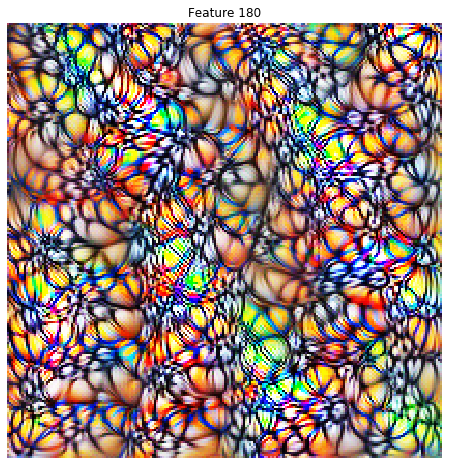

In [5]:
visualize_conv_exp(m[0][6][5], [180])